In [1]:
#Python "essentials"
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import glob
import itertools
import cv2
import json

from TauT_Mapper import TauT
from WaferMapper import WaferMap
from MSI_Transition_Finder import MSI_Transition_Finder 
#These are the librarires that Max and I have built
from cookb_signalsmooth import *
from edge_finder import *
from SARA_cornell_funcs import *
#for image processing and map stitching
import PIL
import PIL.Image as Image

import imutils
from skimage.measure import block_reduce
import imageio
import math
from scipy.interpolate import interp1d
#optimization algorithms require some of this
from scipy import optimize, signal
from scipy import ndimage

import matplotlib as mpl
from matplotlib import gridspec
mpl.rcParams['figure.dpi'] = 150
import colorsys
import matplotlib.backends.backend_pdf as PDF_saver

#defined Functions
def CenterFinding(signal,sparam,window_len=0,filt=False,plotting=False):
    ssig = ndimage.gaussian_filter1d(signal,sparam)
    mid = int(0.5*len(ssig))
    if filt == True:
        corr = ndimage.correlate(ssig,ssig[::-1],mode='wrap')[(mid-window_len):(mid+window_len)]
    else:
        corr = ndimage.correlate(ssig,ssig[::-1],mode='wrap')
    center = (len(ssig))*0.5 + (np.argmax(corr)-(len(corr))*0.5)*0.5
    if plotting == True:
        plt.figure()
        plt.plot(signal,c='dodgerblue')
        plt.plot(ssig,c='goldenrod')
        plt.axvline(center,c='darkorchid')
        plt.show()
    return center

def GradSigNormAndCenter(signal,pixelsize,sparam=0.5,CFon=True,plotting=False):
    pxs = pixelsize
    grad = signal
    if CFon==True:
        center_idx = CenterFinding(grad,sparam)
    else:
        center_idx = int(len(signal)*0.5)
    Cgrad = center_idx*pxs
    xgrad = np.linspace(0,pxs*len(grad),len(grad))

    SplinedFunction = interp1d(xgrad,grad,kind='cubic')
    if plotting == True:
        plt.plot(xgrad,grad)
        plt.axvline(Cgrad,c='goldenrod')
        plt.show()
        plt.close()
    return SplinedFunction,grad,xgrad,center_idx

def bestPC(x,fopt,fspec,shift_tol=20,plotting=False):
    #remove DC component
    opt = fopt(x)
    spec = fspec(x)
    optmod = opt-np.mean(opt) 
    specmod = spec-np.mean(spec)
    dx = x[1]-x[0]
    mid = int(np.round(0.5*(len(x))))
    
    PCs=[]
    search_window = np.linspace(-shift_tol,shift_tol,2*shift_tol+1)
    for mc in search_window:
    #correct allowed dimension
        xmod = x-mc*dx
        minx = max(min(x),min(xmod))
        maxx = min(max(x),max(xmod))
    #     print(minx,maxx)
        newx = np.round(np.linspace(minx,maxx,501),decimals=1)
    #     print(newx)

        nfopt = interp1d(newx,fopt(newx),kind='cubic')
        nfspec = interp1d(newx,spec,kind='cubic')

        PC=np.round(scipy.stats.pearsonr(nfopt(newx),nfspec(newx))[0],decimals=3)
        PCs.append(PC)
        
    mc = search_window[PCs==max(PCs)][0]
    
    xmod = x-mc*dx
    minx = max(min(x),min(xmod))
    maxx = min(max(x),max(xmod))
#     print(minx,maxx)
    newx = np.round(np.linspace(minx,maxx,501),decimals=1)
#     print(newx)

    nfopt = interp1d(newx,fopt(newx),kind='cubic')
    nfspec = interp1d(newx,spec,kind='cubic')
    PC = np.round(scipy.stats.pearsonr(nfopt(newx),nfspec(newx))[0],decimals=3)
    xshift=mc*dx
    
    # plotting to troubleshoot
    if plotting == True:
        fig,ax = plt.subplots(3,1,constrained_layout=True)
        ax[0].plot(x,optmod)
        ax[0].plot(x,specmod)
#         ax[1].plot(cor,'dodgerblue')
        ax[1].plot(search_window,PCs)
        ax[2].plot(newx,nfopt(newx))
        ax[2].plot(newx,nfspec(newx))
        
        plt.show()
        plt.close()
    return xshift, PC, newx, nfopt, nfspec

def get_N_HexCol(N=5):
    HSV_tuples = [(x * 1.0 / N, 0.5, 0.5) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out

def symmetrize(x,sig,center):

    xmod1 = x-center
    left = xmod1[xmod1<0]
    right = xmod1[xmod1>0]
    fsignal = interp1d(xmod1,sig,kind='cubic')
    
    minx = min(max(abs(left)),max(abs(right)))
    xmod = np.round(np.linspace(-minx,minx,len(xmod1)),decimals=5)
    left = xmod[xmod<0]
    right = xmod[xmod>0]
    
    lsig = fsignal(left)
    rsig = fsignal(right)
    avg_opt = (lsig+rsig[::-1])*0.5
    sym_opt = np.hstack((avg_opt,fsignal(0),avg_opt[::-1]))
    xmod = np.linspace(-minx,minx,len(sym_opt))
    sym_sig = interp1d(xmod,sym_opt,kind='cubic')
    
    return sym_sig,xmod


def Spectroscopy_Transiton_Finder(spec_map,cond='string',Gpromfilt=0,h_thresh=10,h_cutoff=12,pix_siz=10,s_param=2,plotting=True):
    TransitionStats = {}
    
    im = spec_map
    grad_im = []
    xpix = im.shape[1]
    for idx in np.arange(im.shape[0]):
        x = np.gradient(im[idx,:])
        x = np.sqrt(x*x)
        grad_im.append(x)
        
    grad_im = np.array(grad_im)
    grad = ndimage.gaussian_filter1d(np.sum(grad_im,axis=0),s_param)
    grad = grad/max(grad)
    
    correlation = ndimage.correlate(grad,grad[::-1],mode='wrap')
    spec_center = (len(correlation))*0.5 + (np.argmax(correlation)-(len(correlation))*0.5)*0.5
    
    a_sigma = abs((np.std(grad[0:h_cutoff])+np.std(grad[-h_cutoff:]))*0.5)
    a_mu = abs((np.mean(grad[0:h_cutoff])+np.mean(grad[-h_cutoff:]))*0.5)
    grad = grad-a_mu
    
    h_filt = h_thresh*a_sigma
#     print(a_mu,a_sigma,h_filt)
    
    spec_trans = signal.find_peaks(grad,prominence=Gpromfilt,width=[0.001*xpix,0.25*xpix],height=h_filt)
    
    TransitionStats['center'] = spec_center
    TransitionStats['TR_idx'] = spec_trans[0]
    TransitionStats['transitions'] = {}
    TransitionStats['transitions']['widths'] = spec_trans[1]['widths']
    TransitionStats['transitions']['FWHMs'] = signal.peak_widths(grad,spec_trans[0],rel_height=0.5)[0]
    TransitionStats['transitions']['heights'] = spec_trans[1]['peak_heights']
    TransitionStats['transitions']['prominences'] = spec_trans[1]['prominences']
    TransitionStats['transitions']['distance_from_center'] = (spec_trans[0]-spec_center)*pix_siz 
    TransitionStats['StripeCenterDistFromImageCenter'] = (spec_trans[0]-spec_center)*pix_siz-(int(0.5*im.shape[1])-spec_center)*pix_siz
    TransitionStats['horizontal FOV']= xpix*pix_siz
    TransitionStats['LSA_condition']= cond
    TransitionStats['gradient'] = grad
    if plotting==True:
        fig,ax = plt.subplots(2,1,constrained_layout=True)
        
        fig.suptitle(cond)
        ax[0].imshow(spec_map,aspect='auto')
        ax[0].axvline(spec_center,c='orchid')
        for tr in spec_trans[0]:
            ax[0].axvline(tr,c='goldenrod')
        ax[1].plot(grad)
        ax[1].axvline(spec_center,c='orchid')
        for tr in spec_trans[0]:
            ax[1].axvline(tr,c='goldenrod')
        
        plt.show()
        plt.close(fig)
    return TransitionStats

def xrd_transition_finder(xrd_map,cond='string',Gpromfilt=0,h_thresh=10,h_cutoff=12,pix_siz=10,s_param=2,plotting=True):
    TransitionStats = {}
    
    im = sharpen_y(xrd_map)
    grad_im = []
    xpix = im.shape[1]
    for idx in np.arange(im.shape[0]):
        x = np.gradient(im[idx,:])
        x = np.sqrt(x*x)
        grad_im.append(x)
        
    grad_im = np.array(grad_im)
    grad = ndimage.gaussian_filter1d(np.sum(grad_im,axis=0),s_param)
    grad = grad/max(grad)    
    
    correlation = ndimage.correlate(grad,grad[::-1],mode='wrap')
    xrd_center = (len(correlation))*0.5 + (np.argmax(correlation)-(len(correlation))*0.5)*0.5
    
    a_sigma = abs((np.std(grad[0:h_cutoff])+np.std(grad[-h_cutoff:]))*0.5)
    a_mu = abs((np.mean(grad[0:h_cutoff])+np.mean(grad[-h_cutoff:]))*0.5)
    grad = grad-a_mu
    
    h_filt = h_thresh*a_sigma
    
    
    xrd_trans = signal.find_peaks(grad,prominence=Gpromfilt,width=[0.001*xpix,0.25*xpix],height=h_filt)
    
    TransitionStats['center'] = xrd_center
    TransitionStats['TR_idx'] = xrd_trans[0]+1
    TransitionStats['transitions'] = {}
    TransitionStats['transitions']['widths'] = xrd_trans[1]['widths']
    TransitionStats['transitions']['FWHMs'] = signal.peak_widths(grad,xrd_trans[0],rel_height=0.5)[0]
    TransitionStats['transitions']['heights'] = xrd_trans[1]['peak_heights']
    TransitionStats['transitions']['prominences'] = xrd_trans[1]['prominences']
    TransitionStats['transitions']['distance_from_center'] = (xrd_trans[0]+1-xrd_center)*pix_siz 
    TransitionStats['StripeCenterDistFromImageCenter'] = (xrd_trans[0]+1-xrd_center)*pix_siz-(int(0.5*im.shape[1])-xrd_center)*pix_siz
    TransitionStats['horizontal FOV'] = xpix*pix_siz
    TransitionStats['LSA_condition'] = cond
    TransitionStats['gradient'] = grad
    if plotting==True:
        fig,ax = plt.subplots(2,1,constrained_layout=True)
        
        fig.suptitle(cond)
        ax[0].imshow(xrd_map,aspect='auto')
        ax[0].axvline(xrd_center,c='orchid')
        for tr in xrd_trans[0]:
            ax[0].axvline(tr,c='goldenrod')
        ax[1].plot(grad)
        ax[1].axvline(xrd_center,c='orchid')
        for tr in xrd_trans[0]:
            ax[1].axvline(tr,c='goldenrod')
        
        plt.show()
        plt.close(fig)
    return TransitionStats

In [2]:
#RGB DATA and Mat Sys name
imagespath = '/home/vandover/Documents/Data/19AJA17_Ga2O3/Images/04-20-2020_white/Images_retake_-500_2700/'
outputpath = '/home/vandover/Documents/Data/19AJA17_Ga2O3/'
pathtoblank = '/home/vandover/Desktop/GrayBullshit.png'
MatSysName='19AJA17_Ga2O3_white_retake'

#parameters for the user to adjust as the need to
RGB = True
mpath = 'null'


#important for setting up your output dictionaries
channel = ['r','g','b','bw']
ImgGrds = {}
xys = {}
fnames = {}
FPs = []
testkeys = []
for file in glob.glob(imagespath+'*.bmp'):
    FPs.append(file)
mirror = cv2.imread(mpath,0)
# for jdx in np.arange(5):
for file in FPs:
    fname = os.path.basename(file)[:-4]
    s = fname.split('_')
    tau = str(int(s[2]))
    T = str(int(s[3]))
    key = '_'.join(('tau',tau,'T',T))
    testkeys.append(key)
    xys[key] = (int(s[0][1:]),int(s[1]))
    ImgGrds[key] = {}
    fnames[key] = fname
    print(key)
    if RGB==True:
        for ch,cchannel in enumerate(['r','g','b']):
            img = np.array(cv2.imread(file)[:,:,ch][400:530,:],dtype='uint8')
            isum = np.sum(img,axis=0)#/np.sum(mirror,axis=0)
            isum = ndimage.gaussian_filter1d(isum,15)
            isum = isum-(isum[-1]-isum[0])/len(isum)*np.arange(len(isum))
            isum = isum/max(isum)
            g = np.gradient(isum)
            g = np.sqrt(g*g)
            g = g/max(g)

            h_cutoff = 150
            
            a_sigma = abs((np.std(g[0:h_cutoff])+np.std(g[-h_cutoff:]))*0.5)
            a_mean = abs((np.mean(g[0:h_cutoff])+np.mean(g[-h_cutoff:]))*0.5)
            h_filt = 3*a_sigma
            xpix = len(g)
            g = g - a_mean
            ImgGrds[key][cchannel] = g


tau_850_T_760
tau_580_T_520
tau_7278_T_880
tau_2317_T_920
tau_700_T_800
tau_3214_T_600
tau_700_T_840
tau_850_T_920
tau_5248_T_880
tau_2729_T_500
tau_1419_T_1360
tau_532_T_920
tau_1023_T_760
tau_4457_T_1280
tau_5248_T_1400
tau_1420_T_1440
tau_10000_T_840
tau_2317_T_1160
tau_2317_T_1440
tau_700_T_560
tau_1419_T_1440
tau_6180_T_1240
tau_2729_T_1400
tau_8570_T_1440
tau_10000_T_640
tau_2317_T_600
tau_869_T_760
tau_3784_T_1400
tau_2729_T_1240
tau_2317_T_1200
tau_1968_T_640
tau_1205_T_1160
tau_1968_T_520
tau_5248_T_840
tau_1205_T_960
tau_8570_T_840
tau_580_T_1320
tau_738_T_840
tau_5248_T_1360
tau_1205_T_880
tau_1205_T_640
tau_1671_T_1040
tau_480_T_1400
tau_5248_T_1000
tau_1968_T_1080
tau_1671_T_1120
tau_738_T_1040
tau_8570_T_1280
tau_700_T_760
tau_2317_T_1400
tau_1023_T_1240
tau_1023_T_1320
tau_1205_T_1440
tau_2729_T_520
tau_869_T_1000
tau_1420_T_1120
tau_1671_T_1240
tau_850_T_1280
tau_5248_T_1040
tau_1419_T_920
tau_400_T_520
tau_7278_T_560
tau_480_T_1280
tau_2317_T_1360
tau_1968_T_1120
tau_2

/home/vandover/anaconda3/envs/murisara/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in ulong_scalars


tau_1419_T_680
tau_7278_T_1040
tau_5248_T_1440
tau_3784_T_1200
tau_1205_T_500
tau_850_T_520
tau_627_T_960
tau_1671_T_1000
tau_3214_T_1200
tau_10000_T_1080
tau_7278_T_720
tau_3214_T_1240
tau_400_T_960
tau_6180_T_680
tau_532_T_840
tau_1419_T_1160
tau_6180_T_880
tau_3784_T_960
tau_5248_T_1160
tau_3214_T_1440
tau_480_T_1360
tau_738_T_760
tau_627_T_800
tau_1419_T_1040
tau_738_T_720
tau_700_T_520
tau_480_T_1440
tau_1023_T_520
tau_10000_T_1000
tau_2729_T_1320
tau_6180_T_600
tau_3214_T_960
tau_3784_T_800
tau_1968_T_680
tau_3784_T_1120
tau_532_T_600
tau_580_T_1240
tau_6180_T_1360
tau_850_T_720
tau_3784_T_1320
tau_7278_T_1080
tau_8570_T_880
tau_4457_T_1080
tau_8570_T_1040
tau_2317_T_1240
tau_5248_T_1240
tau_1023_T_680
tau_850_T_560
tau_850_T_1400
tau_532_T_1160
tau_700_T_880
tau_3214_T_500
tau_480_T_840
tau_1023_T_600
tau_1023_T_840
tau_1023_T_800
tau_580_T_880
tau_1671_T_760
tau_400_T_680
tau_3784_T_1040
tau_7278_T_600
tau_2317_T_800
tau_850_T_1000
tau_5248_T_760
tau_2317_T_720
tau_10000_T_920


tau_850_T_1120
tau_7278_T_1400
tau_700_T_720
tau_2729_T_1360
tau_532_T_1320


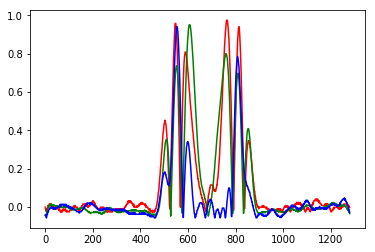

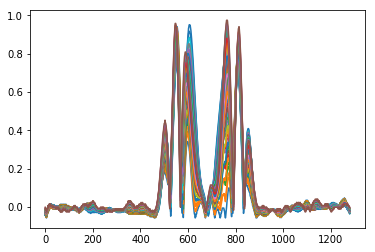

In [10]:
rgb_grads = []
key = 'tau_532_T_1320'
fig,ax = plt.subplots(1,1)
for ch in ['r','g','b']:
    g = ImgGrds[key][ch]
    rgb_grads.append(g)
    ax.plot(g,c=ch)
plt.show()
plt.close(fig)

rgb_grads = np.array(rgb_grads)


mix_grads = []
fig,ax = plt.subplots(1,1)
weights = [
    [0.0, 0.0, 1.0],
    [0.0, 0.1, 0.9],
    [0.0, 0.2, 0.8],
    [0.0, 0.3, 0.7],
    [0.0, 0.4, 0.6],
    [0.0, 0.5, 0.5],
    [0.0, 0.6, 0.4],
    [0.0, 0.7, 0.3],
    [0.0, 0.8, 0.2],
    [0.0, 0.9, 0.1],
    [0.0, 1.0, 0.0],
    [0.1, 0.0, 0.9],
    [0.1, 0.1, 0.8],
    [0.1, 0.2, 0.7],
    [0.1, 0.3, 0.6],
    [0.1, 0.4, 0.5],
    [0.1, 0.5, 0.4],
    [0.1, 0.6, 0.3],
    [0.1, 0.7, 0.2],
    [0.1, 0.8, 0.1],
    [0.1, 0.9, 0.0],
    [0.2, 0.0, 0.8],
    [0.2, 0.1, 0.7],
    [0.2, 0.2, 0.6],
    [0.2, 0.3, 0.5],
    [0.2, 0.4, 0.4],
    [0.2, 0.5, 0.3],
    [0.2, 0.6, 0.2],
    [0.2, 0.7, 0.1],
    [0.2, 0.8, 0.0],
    [0.3, 0.0, 0.7],
    [0.3, 0.1, 0.6],
    [0.3, 0.2, 0.5],
    [0.3, 0.3, 0.4],
    [0.3, 0.4, 0.3],
    [0.3, 0.5, 0.2],
    [0.3, 0.6, 0.1],
    [0.3, 0.7, 0.0],
    [0.4, 0.0, 0.6],
    [0.4, 0.1, 0.5],
    [0.4, 0.2, 0.4],
    [0.4, 0.3, 0.3],
    [0.4, 0.4, 0.2],
    [0.4, 0.5, 0.1],
    [0.4, 0.6, 0.0],
    [0.5, 0.0, 0.5],
    [0.5, 0.1, 0.4],
    [0.5, 0.2, 0.3],
    [0.5, 0.3, 0.2],
    [0.5, 0.4, 0.1],
    [0.5, 0.5, 0.0],
    [0.6, 0.0, 0.4],
    [0.6, 0.1, 0.3],
    [0.6, 0.2, 0.2],
    [0.6, 0.3, 0.1],
    [0.6, 0.4, 0.0],
    [0.7, 0.0, 0.3],
    [0.7, 0.1, 0.2],
    [0.7, 0.2, 0.1],
    [0.7, 0.3, 0.0],
    [0.8, 0.0, 0.2],
    [0.8, 0.1, 0.1],
    [0.8, 0.2, 0.0],
    [0.9, 0.0, 0.1],
    [0.9, 0.1, 0.0],
    [1.0, 0.0, 0.0]]
for rw,gw,bw in weights:
    avg = np.average(rgb_grads,axis=0,weights=[rw,gw,bw])
    mix_grads.append(avg)
    ax.plot(avg)
plt.show()

In [6]:
#This is optical reflectance data and analysis
data_filepath = '/home/vandover/Documents/Data/19AJA17_Ga2O3/Spectroscopy/04-20-2020/'
Blank_filepath = '/home/vandover/Documents/Data/19AJA17_Ga2O3/Spectroscopy/04-20-2020/Blank/blank_00.csv'
Mirror_filepath = '/home/vandover/Documents/Data/19AJA17_Ga2O3/Spectroscopy/04-20-2020/Mirror/mirror_00.csv'

In [7]:
ReflTrs = {}
FPs = []
keys = []
#extracting the data from the .csv files
for i in glob.glob(data_filepath+'*.csv'):
    #extracting lasGO coordinates and anneal conditions
    filename = os.path.basename(i)
    x = filename.split('_')
    string = '_'.join(['tau',str(int(x[2])),'T',str(int(x[3][:-4]))])
    FPs.append(i)
    keys.append(string)

for idx in np.arange(len(FPs)):#np.arange(5)
    data_fn = FPs[idx]
    string = keys[idx]
    smooth_data = get_spects(data_fn,Mirror_filepath,Blank_filepath)
    wl = smooth_data[0]
    wl_range = wl[(wl>=400) & (wl<= 850)]
    #Dictionary Generation
    print(idx)
    Reflmap = smooth_data[2][[(wl>=400) & (wl<= 850)][0],:]
    ReflTrs[string] =  Spectroscopy_Transiton_Finder(Reflmap,Gpromfilt=.05,h_thresh=3,h_cutoff=10,s_param=.5,cond=key,plotting=False)['gradient']
wl = wl_range

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
OG_path = '/home/vandover/Documents/Data/19AJA17_Ga2O3/Ga2O3_19AJA17_all_oned.h5'

file = h5.File(OG_path,'r')
xrd_exp_files = file['exp']
data = []
xrdGrds = {}
x = []
for idx, params in enumerate(xrd_exp_files):
    anneal_conditions = xrd_exp_files[params]
    stripe = list(anneal_conditions.keys())
    stripe.sort(key=int)
    name = params
    print(params)
    xpos,ypos = (anneal_conditions.attrs['xw'],anneal_conditions.attrs['yw'])
    

    for jdx, scan_num in enumerate(stripe):        
        Q,I = anneal_conditions[scan_num]['integrated_1d']
        
        if scan_num == '0':
            data = np.append(data, I[:-24], axis=0)
        else:
            data = np.vstack((data,I[:-24]))


    xrdGrds[name] = xrd_transition_finder(data.T,h_thresh=3,h_cutoff=10,s_param=0.5,cond=name,plotting=False)['gradient']


    data = []   

    



tau_10000_T_1000
tau_10000_T_1040
tau_10000_T_1080
tau_10000_T_1120
tau_10000_T_1200
tau_10000_T_1240
tau_10000_T_1280
tau_10000_T_1320
tau_10000_T_1360
tau_10000_T_1400
tau_10000_T_1440
tau_10000_T_500
tau_10000_T_520
tau_10000_T_560
tau_10000_T_600
tau_10000_T_640
tau_10000_T_680
tau_10000_T_720
tau_10000_T_760
tau_10000_T_800
tau_10000_T_840
tau_10000_T_880
tau_10000_T_920
tau_10000_T_960
tau_1023_T_1000
tau_1023_T_1040
tau_1023_T_1080
tau_1023_T_1120
tau_1023_T_1160
tau_1023_T_1200
tau_1023_T_1240
tau_1023_T_1280
tau_1023_T_1320
tau_1023_T_1360
tau_1023_T_1400
tau_1023_T_1440
tau_1023_T_500
tau_1023_T_520
tau_1023_T_560
tau_1023_T_600
tau_1023_T_640
tau_1023_T_680
tau_1023_T_720
tau_1023_T_760
tau_1023_T_800
tau_1023_T_840
tau_1023_T_880
tau_1023_T_920
tau_1023_T_960
tau_1205_T_1000
tau_1205_T_1040
tau_1205_T_1080
tau_1205_T_1120
tau_1205_T_1160
tau_1205_T_1200
tau_1205_T_1240
tau_1205_T_1280
tau_1205_T_1320
tau_1205_T_1360
tau_1205_T_1400
tau_1205_T_1440
tau_1205_T_500
tau_1205_T_

tau_738_T_600
tau_738_T_640
tau_738_T_680
tau_738_T_720
tau_738_T_760
tau_738_T_800
tau_738_T_840
tau_738_T_880
tau_738_T_920
tau_738_T_960
tau_850_T_1000
tau_850_T_1040
tau_850_T_1080
tau_850_T_1120
tau_850_T_1160
tau_850_T_1200
tau_850_T_1240
tau_850_T_1280
tau_850_T_1320
tau_850_T_1360
tau_850_T_1400
tau_850_T_1440
tau_850_T_500
tau_850_T_520
tau_850_T_560
tau_850_T_600
tau_850_T_640
tau_850_T_680
tau_850_T_720
tau_850_T_760
tau_850_T_800
tau_850_T_840
tau_850_T_880
tau_850_T_920
tau_850_T_960
tau_8570_T_1000
tau_8570_T_1040
tau_8570_T_1080
tau_8570_T_1120
tau_8570_T_1160
tau_8570_T_1200
tau_8570_T_1240
tau_8570_T_1280
tau_8570_T_1320
tau_8570_T_1360
tau_8570_T_1400
tau_8570_T_1440
tau_8570_T_500
tau_8570_T_520
tau_8570_T_560
tau_8570_T_600
tau_8570_T_640
tau_8570_T_680
tau_8570_T_720
tau_8570_T_760
tau_8570_T_800
tau_8570_T_840
tau_8570_T_880
tau_8570_T_920
tau_8570_T_960
tau_869_T_1000
tau_869_T_1040
tau_869_T_1080
tau_869_T_1120
tau_869_T_1160
tau_869_T_1200
tau_869_T_1240
tau_86

In [34]:
key = 'tau_532_T_1320'
gspec = ReflTrs[key]
gxrd = xrdGrds[key]
gopt = mix_grads[0]
# fig,ax = plt.subplots(3,1)
# for rgb in mix_grads:
#     ax[0].plot(rgb)
# ax[1].plot(gspec)
# ax[2].plot xps = 10
sps = 10
ops = 1.176
ops1 = 10
xps = 10
shiftol = 51
TechPSs = [ops,sps,xps]
TechNames = ['Optical','Spectroscopy','XRD']


oscale = len(gopt)*ops
sscale = len(gspec)*sps
xscale = len(gxrd)*xps    

#locating the smallest one and determining the appropriate crop pixel
scales = [oscale,sscale,xscale]
minscale = min(scales)

oscale = int(np.round(0.5*(oscale-minscale)/ops))
sscale = int(np.round(0.5*(sscale-minscale)/sps))
xscale = int(np.round(0.5*(xscale-minscale)/xps))
scales = [oscale,sscale,xscale]
print(scales)
#loading the technique maps
gspec = gspec[sscale:-sscale]
PCs = {}
for gdx,gopt in enumerate(mix_grads):
    gopt = gopt[oscale:-oscale]
    TechGrads = [gopt,gspec,gxrd]
    PCs[str(gdx)] = {}
    for adx,bdx in [(0,1),(0,2),(1,2)]:
        
        #loading in the technique pairs Opt:Spec, Opt:XRD, Spec:XRD
        a = TechGrads[adx]
        b = TechGrads[bdx]
        aps = TechPSs[adx]
        bps = TechPSs[bdx]
        aname = TechNames[adx]
        bname = TechNames[bdx]
        
        
        #Turning the gradients into  splines for the optimized correlation functions
        afxn,anormgrad,axgrad,acidx = GradSigNormAndCenter(signal=a,pixelsize=aps,CFon=True,plotting=False)
        bfxn,bnormgrad,bxgrad,bcidx = GradSigNormAndCenter(signal=b,pixelsize=bps,CFon=True,plotting=False)


        # finding the shared space for the two techniques to be compared
        maxx = min(max(axgrad),max(bxgrad)) 
        sharedx = np.linspace(0,maxx,501)
        
        # optimizes the Gradients over the shared space within some distance from eachother
        xshift, PC0, newx, nafxn, nbfxn = bestPC(sharedx,bfxn,afxn,shift_tol=shiftol,plotting=False)
        PCs[str(gdx)][f'PC for {aname} and {bname}'] = PC0
#         PC[key][mix][f'PC for {aname} and {bname}'] = PC0

[211, 50, 0]


In [25]:
if 'tau_10000_T_1160' not in list(xrdGrds):
    xrdGrds['tau_10000_T_1160'] = xrdGrds['tau_10000_T_1120']
    # where to write the output document to
basepath = '/home/vandover/Documents/Data/19AJA17_Ga2O3/'

# This is more important when comparing the optical to either technique, because of the 
# resolution difference
resample = False
shiftol = 51

# there is a slight discrepancy with the dwells for the active learned samples vs what was requested
# it is a rounding issue that can be overcome by sorting the same way. 
xkeys = dwellsort(list(xrdGrds),Temp=True) 
okeys = dwellsort(list(ImgGrds),Temp=True)

# the dictionary that will house the gradient information for easier correlation
graddict = {}

# the correlation statistics are stored here
PC = {}
jazz1 = np.arange(len(xkeys))[:155]
# iterating through the conditions and extracting all the information from each of the techniques
for idx in jazz1:
    #This is a diagnostic parameter important for determining where stripes were annealed
    xpos = xys[okeys[idx]][0]
    ypos = xys[okeys[idx]][1]
    xkey = xkeys[idx]
    key = okeys[idx]

    #inputing the pixel sizes once. Different sets of data were collected at different resolutions
    xps = 10
    sps = 10
    ops = 1.176
    ops1 = 10
    TechPSs = [ops,sps,xps]
    TechNames = ['Optical','Spectroscopy','XRD']
    
    # each technique spans a different anneal space. Each technique needs to be tailored accordingly.
    # For this sample, the x-ray maps span 1 mm, whereas the optical and spectroscopy are ~1.2 mm 
    # and 2.01 mm respectively. This will change depending on the material system, the zoom of the
    # optical camera, the space collected by the spectroscopy and that of the XRD. 
    
    #defining the anneal space span for each technique
    oscale = len(ImgGrds[key]['r'])*ops
    sscale = len(ReflTrs[key])*sps
    xscale = len(xrdGrds[xkey])*xps
    
    #locating the smallest one and determining the appropriate crop pixel
    scales = [oscale,sscale,xscale]
    minscale = min(scales)

    oscale = int(np.round(0.5*(oscale-minscale)/ops))
    sscale = int(np.round(0.5*(sscale-minscale)/sps))
    xscale = int(np.round(0.5*(xscale-minscale)/xps))
    scales = [oscale,sscale,xscale]
    
    PC[key] = {}
    #Reducing RGB image down to grayscale with artificially optimizing the contrast via mixing RGB components
    #ChannelOptimization
    # for rw in np.linspace(0.1,0.3,3):
    #     for gw in np.linspace(0.6,0.8,3):
    #         for bw in np.linspace(0.1,0.5,3):

    allmix = [
    [0.0, 0.0, 1.0],
    [0.0, 0.1, 0.9],
    [0.0, 0.2, 0.8],
    [0.0, 0.3, 0.7],
    [0.0, 0.4, 0.6],
    [0.0, 0.5, 0.5],
    [0.0, 0.6, 0.4],
    [0.0, 0.7, 0.3],
    [0.0, 0.8, 0.2],
    [0.0, 0.9, 0.1],
    [0.0, 1.0, 0.0],
    [0.1, 0.0, 0.9],
    [0.1, 0.1, 0.8],
    [0.1, 0.2, 0.7],
    [0.1, 0.3, 0.6],
    [0.1, 0.4, 0.5],
    [0.1, 0.5, 0.4],
    [0.1, 0.6, 0.3],
    [0.1, 0.7, 0.2],
    [0.1, 0.8, 0.1],
    [0.1, 0.9, 0.0],
    [0.2, 0.0, 0.8],
    [0.2, 0.1, 0.7],
    [0.2, 0.2, 0.6],
    [0.2, 0.3, 0.5],
    [0.2, 0.4, 0.4],
    [0.2, 0.5, 0.3],
    [0.2, 0.6, 0.2],
    [0.2, 0.7, 0.1],
    [0.2, 0.8, 0.0],
    [0.3, 0.0, 0.7],
    [0.3, 0.1, 0.6],
    [0.3, 0.2, 0.5],
    [0.3, 0.3, 0.4],
    [0.3, 0.4, 0.3],
    [0.3, 0.5, 0.2],
    [0.3, 0.6, 0.1],
    [0.3, 0.7, 0.0],
    [0.4, 0.0, 0.6],
    [0.4, 0.1, 0.5],
    [0.4, 0.2, 0.4],
    [0.4, 0.3, 0.3],
    [0.4, 0.4, 0.2],
    [0.4, 0.5, 0.1],
    [0.4, 0.6, 0.0],
    [0.5, 0.0, 0.5],
    [0.5, 0.1, 0.4],
    [0.5, 0.2, 0.3],
    [0.5, 0.3, 0.2],
    [0.5, 0.4, 0.1],
    [0.5, 0.5, 0.0],
    [0.6, 0.0, 0.4],
    [0.6, 0.1, 0.3],
    [0.6, 0.2, 0.2],
    [0.6, 0.3, 0.1],
    [0.6, 0.4, 0.0],
    [0.7, 0.0, 0.3],
    [0.7, 0.1, 0.2],
    [0.7, 0.2, 0.1],
    [0.7, 0.3, 0.0],
    [0.8, 0.0, 0.2],
    [0.8, 0.1, 0.1],
    [0.8, 0.2, 0.0],
    [0.9, 0.0, 0.1],
    [0.9, 0.1, 0.0],
    [1.0, 0.0, 0.0]]
    print(key)
    for rw,gw,bw in allmix:
        mix = f'{rw} {gw} {bw}'
        print(rw,gw,bw)
        # Taking the gradients along the correct scale
        ograd = np.average(np.array([ImgGrds[key][cch] for cch in ['r','g','b']]),axis=0,weights=[rw,gw,bw])
    #     ograd = ostats['Gradient']
        sgrad = ReflTrs[key]
        xgrad = xrdGrds[xkey]
        
        for grad in [ograd,sgrad,xgrad]:
            grad[0] = np.mean(grad[:15])
            grad[-1] = np.mean(grad[-15:])
        
        TechGrads = [ograd,sgrad,xgrad]
        
        if resample==True:
            y = signal.resample(ograd,len(xgrad))
            ops = 10
            TechPSs = [ops,sps,xps]
            TechGrads = [y,sgrad,xgrad]

        
        # Gotta correlate the gradients now. The off diagonals of the correlation matrix is the 
        PC[key][mix] = {}
        for adx,bdx in [(0,1),(0,2),(1,2)]:
            
            #loading in the technique pairs Opt:Spec, Opt:XRD, Spec:XRD
            a = TechGrads[adx]
            b = TechGrads[bdx]
            aps = TechPSs[adx]
            bps = TechPSs[bdx]
            aname = TechNames[adx]
            bname = TechNames[bdx]
    #         print(aname,bname)
    #         print(len(a),len(b))
            
            #Turning the gradients into  splines for the optimized correlation functions
            afxn,anormgrad,axgrad,acidx = GradSigNormAndCenter(signal=a,pixelsize=aps,CFon=True,plotting=False)
            bfxn,bnormgrad,bxgrad,bcidx = GradSigNormAndCenter(signal=b,pixelsize=bps,CFon=True,plotting=False)

                       
            # finding the shared space for the two techniques to be compared
            maxx = min(max(axgrad),max(bxgrad)) 
            sharedx = np.linspace(0,maxx,501)

            # optimizes the Gradients over the shared space within some distance from eachother
            xshift, PC0, newx, nafxn, nbfxn = bestPC(sharedx,bfxn,afxn,shift_tol=shiftol,plotting=False)
            PC[key][mix][f'PC for {aname} and {bname}'] = PC0

PCCfp = '/home/vandover/Documents/Data/19AJA17_Ga2O3/RGB_mixtures.json'
with open(PCCfp,'w') as json_file:
    json.dump(PC,json_file)


tau_400_T_500
0.0 0.0 1.0
0.0 0.1 0.9
0.0 0.2 0.8
0.0 0.3 0.7
0.0 0.4 0.6
0.0 0.5 0.5
0.0 0.6 0.4
0.0 0.7 0.3


KeyboardInterrupt: 

In [35]:
jazz1 = np.arange(len(xkeys))[:155]
jazz2 = np.arange(len(xkeys))[155:310]
jazz3 = np.arange(len(xkeys))[310:465]
jazz4 = np.arange(len(xkeys))[465:]

array([465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477,
       478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490,
       491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503,
       504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516,
       517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529,
       530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542,
       543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555,
       556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568,
       569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581,
       582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594,
       595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607,
       608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620,
       621, 622, 623, 624])

In [31]:
617/4

154.25